<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Autoencoder_CNN_Mamba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from mamba_ssm import Mamba

In [ ]:
## https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

dim_n=8 #conv. vidinis dydis


# Define the autoencoder architecture
class Autoencoder_m(nn.Module):
    def __init__(self):
        super(Autoencoder_m, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, dim_n, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim_n, 32,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        )
        # layer norm

        self.dim = dim_n
        self.norm = nn.LayerNorm(dim_n)
        self.mamba = Mamba(
            d_model=dim_n,
            d_state=16,
            d_conv=4,
            expand=4,
        )

    def forward(self, x):
        x = self.encoder(x)

        # mambos pradzia
        if x.dtype == torch.float16:
            x = x.type(torch.float32)
        B, C = x.shape[:2]
        #assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        x_mamba = self.mamba(x_norm)
        x = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)
        # mambos pabaiga

        x = self.decoder(x)
        return x


# Initialize the autoencoder
model_m = Autoencoder_m()
model_m.cuda()

Autoencoder_m(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
  (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (mamba): Mamba(
    (in_proj): Linear(in_features=8, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (act): SiLU()
    (x_proj): Linear(in_features=32, out_features=33, bias=False)
    (dt_proj): Li

In [ ]:


# Define transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load dataset
train_dataset = datasets.Flowers102(root='flowers',
                                    split='train',
                                    transform=transform,
                                    download=True)
test_dataset = datasets.Flowers102(root='flowers',
                                   split='test',
                                   transform=transform)
# Define the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4*128,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4*128)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_m.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_m.parameters(), lr=0.001,
                             weight_decay=1e-5)

# Train the autoencoder_m
num_epochs = 100
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model_m(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model
#torch.save(model.state_dict(), 'conv_autoencoder.pth')

cuda
Epoch [1/100], Loss: 0.0207
Epoch [6/100], Loss: 0.0093
Epoch [11/100], Loss: 0.0073
Epoch [16/100], Loss: 0.0065
Epoch [21/100], Loss: 0.0066
Epoch [26/100], Loss: 0.0062
Epoch [31/100], Loss: 0.0060
Epoch [36/100], Loss: 0.0059
Epoch [41/100], Loss: 0.0055
Epoch [46/100], Loss: 0.0055
Epoch [51/100], Loss: 0.0056
Epoch [56/100], Loss: 0.0054
Epoch [61/100], Loss: 0.0052
Epoch [66/100], Loss: 0.0054
Epoch [71/100], Loss: 0.0051
Epoch [76/100], Loss: 0.0051
Epoch [81/100], Loss: 0.0049
Epoch [86/100], Loss: 0.0049
Epoch [91/100], Loss: 0.0050
Epoch [96/100], Loss: 0.0049


<Figure size 1500x1000 with 0 Axes>

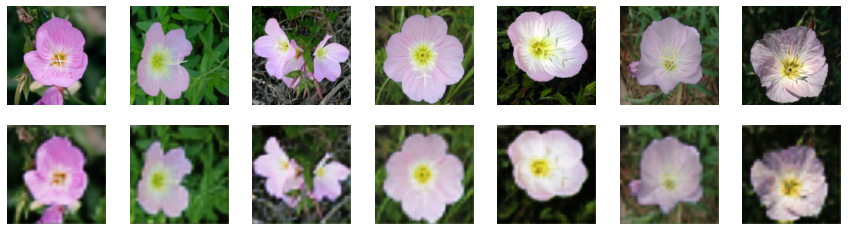

In [ ]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model_m(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [ ]:
## no Mamba

In [ ]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x


# Initialize the autoencoder
model = Autoencoder()
model.cuda()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [ ]:
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

# Train the autoencoder_m

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model
#torch.save(model.state_dict(), 'conv_autoencoder.pth')

Epoch [1/100], Loss: 0.0941
Epoch [6/100], Loss: 0.0885
Epoch [11/100], Loss: 0.0826
Epoch [16/100], Loss: 0.0723
Epoch [21/100], Loss: 0.0557
Epoch [26/100], Loss: 0.0411
Epoch [31/100], Loss: 0.0304
Epoch [36/100], Loss: 0.0255
Epoch [41/100], Loss: 0.0214
Epoch [46/100], Loss: 0.0189
Epoch [51/100], Loss: 0.0173
Epoch [56/100], Loss: 0.0153
Epoch [61/100], Loss: 0.0141
Epoch [66/100], Loss: 0.0131
Epoch [71/100], Loss: 0.0123
Epoch [76/100], Loss: 0.0115
Epoch [81/100], Loss: 0.0111
Epoch [86/100], Loss: 0.0097
Epoch [91/100], Loss: 0.0089
Epoch [96/100], Loss: 0.0080


<Figure size 1500x1000 with 0 Axes>

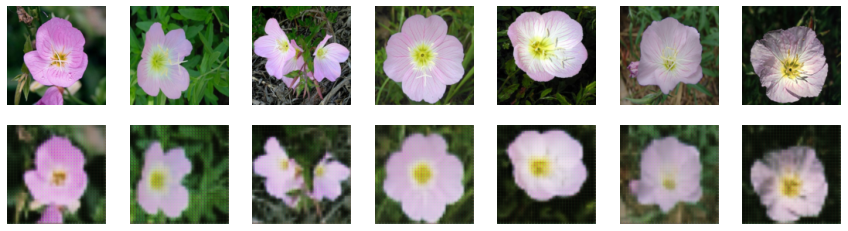

In [ ]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()